##  Project 5 Vehicle Detection and Tracking


In [1]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from tool_functions import *
#%matplotlib qt
%matplotlib inline


/home/pachinko/anaconda3/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import params
### TODO: Tweak these parameters and see how the results change.
#color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#color_space = 'HSV'
color_space = params.color_space
# HOG orientations
orient = params.orient
pix_per_cell = params.pix_per_cell     # HOG pixels per cell
cell_per_block = params.cell_per_block # HOG cells per block
hog_channel = params.hog_channel # Can be 0, 1, 2, or "ALL"
spatial_size = params.spatial_size # Spatial binning dimensions
hist_bins = params.hist_bins    # Number of histogram bins

spatial_feat = params.spatial_feat # Spatial features on or off
hist_feat = params.hist_feat # Histogram features on or off
hog_feat = params.hog_feat # HOG features on or off
y_start_stop = params.y_start_stop # Min and max in y to search in slide_window()

# test on findcars.
# ystart = 400
ystart = 350
ystop = 656
scale = 1.5

# global variables:
X_scaler = None


In [3]:
from pathlib import Path

clf_file = Path("save/clf.pickle")
scaler_file = Path("save/x_scaler.pickle")
if clf_file.is_file() & scaler_file.is_file():
    print(clf_file,  "exist! Don't train classifier, just load it.")
    with open('save/clf.pickle', 'rb') as f:
        clf2 = pickle.load(f)
        print(clf2)    
    with open('save/x_scaler.pickle', 'rb') as f:
        global X_scaler
        X_scaler = pickle.load(f)
else:
    print(" One or more model files not exist, start training classifier...")
    clf2 = train_classifier()

print('cell passed.')

/home/pachinko/anaconda3/envs/py35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


 One or more model files not exist, start training classifier...
cars size :  8792
notcars size :  8968
after sampled: 
cars size :  8792
notcars size :  8968
elapsed_time :  0.08332943916320801
car_features shape:,  8792
X:,  (17760, 1788)  X_scaler:  StandardScaler(copy=True, with_mean=True, with_std=True)
Using: 9 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1788
3.78 Seconds to train SVC...
Test Accuracy of SVC =  0.9828
elapsed_time :  69.4237928390503
cell passed.


elapsed_time :  0.07036399841308594


/home/pachinko/anaconda3/envs/py35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


in draw_boxes
type params : <class 'module'> params : <module 'params' from '/home/pachinko/codes/udacity/p5-carnd-vehicle-detection/params.py'>
orient : 9


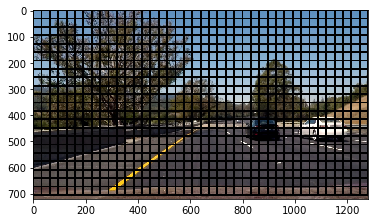

in draw_boxes
type params : <class 'module'> params : <module 'params' from '/home/pachinko/codes/udacity/p5-carnd-vehicle-detection/params.py'>
orient : 9


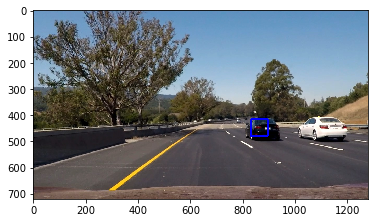

elapsed_time :  3.0187714099884033
cell passed.


In [4]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from tool_functions import *

#%matplotlib qt
%matplotlib inline
start_time = time.time()

image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
# windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(48, 48), xy_overlap=(0.5, 0.5))
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5))

elapsed_time = time.time() - start_time
print('elapsed_time : ', elapsed_time )

hot_windows = search_windows(image, windows, clf2, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel
                        ,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
                            )

window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
plt.show()

elapsed_time = time.time() - start_time
print('elapsed_time : ', elapsed_time )


print('cell passed.')

images :  ['test_images/test2.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg', 'test_images/test1.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg']


/home/pachinko/anaconda3/envs/py35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


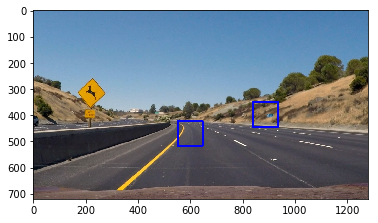

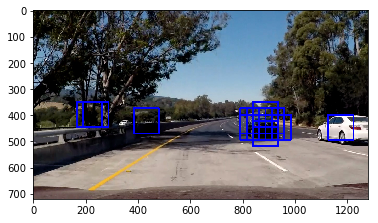

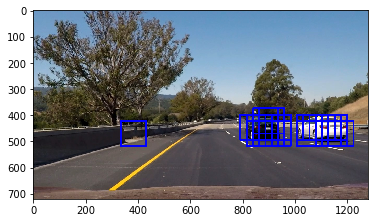

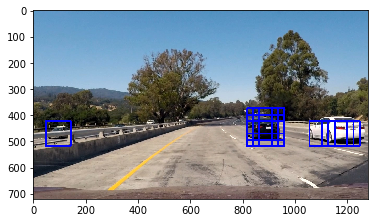

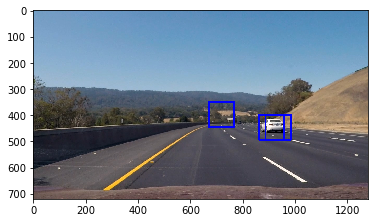

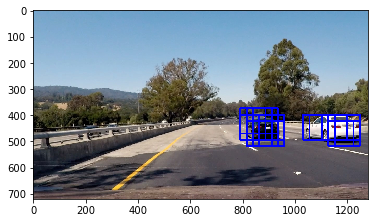

cell passed.


In [5]:
sample_window_cnt = 64
#sample_window_cnt = 128

filenames = glob.glob('test_images/*.jpg')
print('images : ', filenames)
for filename in filenames:
    img = mpimg.imread(filename)
    out_img, rect = find_cars(img, ystart, ystop, scale, clf2, X_scaler, orient, 
                              pix_per_cell, cell_per_block, spatial_size, hist_bins, sample_window_cnt)

    plt.imshow(out_img)
    plt.show()
print('cell passed.')

images :  ['test_images/test2.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg', 'test_images/test1.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg']


/home/pachinko/anaconda3/envs/py35/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


bbox_list len:  2
numpy.where( average > heatmap_threshold ) : (array([], dtype=int64), array([], dtype=int64))  
  []
0 cars found


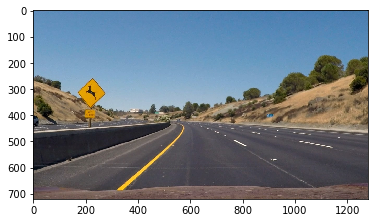

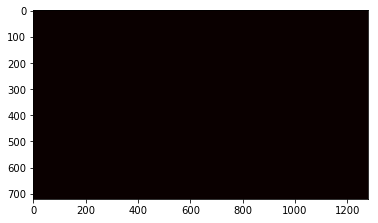

bbox_list len:  15
numpy.where( average > heatmap_threshold ) : (array([374, 374, 374, ..., 493, 493, 493]), array([840, 841, 842, ..., 933, 934, 935]))  
  [ 2.5  2.5  2.5 ...,  2.   2.   2. ]
1 cars found


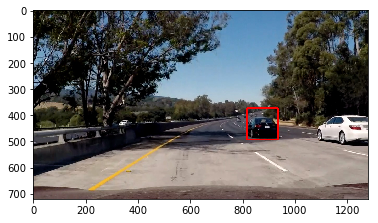

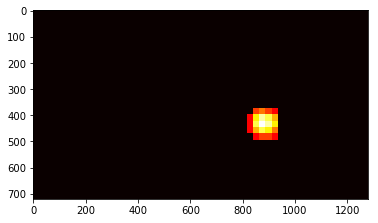

bbox_list len:  21
numpy.where( average > heatmap_threshold ) : (array([374, 374, 374, ..., 517, 517, 517]), array([840, 841, 842, ..., 909, 910, 911]))  
  [ 2.          2.          2.         ...,  1.66666667  1.66666667
  1.66666667]
2 cars found


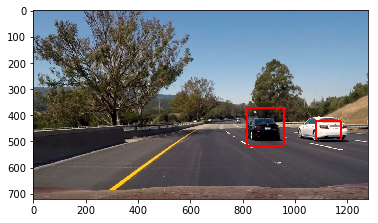

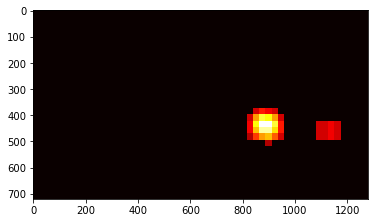

bbox_list len:  14
numpy.where( average > heatmap_threshold ) : (array([374, 374, 374, ..., 517, 517, 517]), array([840, 841, 842, ..., 909, 910, 911]))  
  [ 2.  2.  2. ...,  2.  2.  2.]
2 cars found


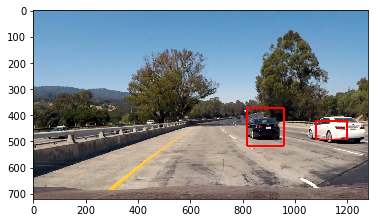

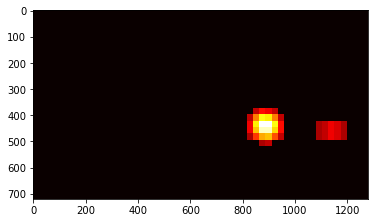

bbox_list len:  3
numpy.where( average > heatmap_threshold ) : (array([374, 374, 374, ..., 493, 493, 493]), array([ 864,  865,  866, ..., 1173, 1174, 1175]))  
  [ 2.2  2.2  2.2 ...,  1.8  1.8  1.8]
2 cars found


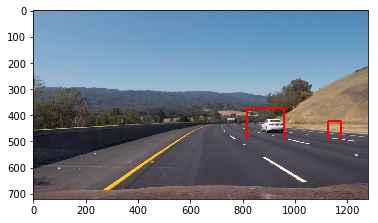

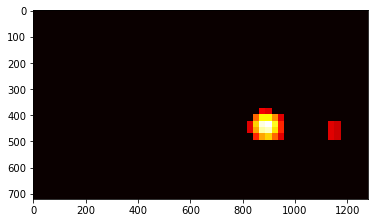

bbox_list len:  16
numpy.where( average > heatmap_threshold ) : (array([374, 374, 374, ..., 517, 517, 517]), array([840, 841, 842, ..., 909, 910, 911]))  
  [ 1.83333333  1.83333333  1.83333333 ...,  1.83333333  1.83333333
  1.83333333]
2 cars found


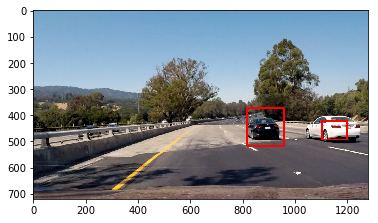

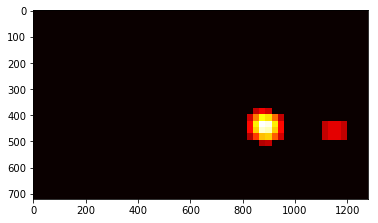

cell passed.


In [6]:

heatmaps.clear()
# testing on def makeheatmap.
filenames = glob.glob('test_images/*.jpg')
print('images : ', filenames)
for filename in filenames:
    img = mpimg.imread(filename)
    out_img, rect = find_cars(img, ystart, ystop, scale, clf2, X_scaler, orient, 
                              pix_per_cell, cell_per_block, spatial_size, hist_bins, sample_window_cnt)

# #    heatmap_threshold = 2.2
#     heatmap_threshold = 15
    heat_img = makeheatmap(img, rect, heatmap_threshold, True)
#     plt.imshow(heat_img)
#     plt.show()

print('cell passed.')
    

In [7]:
# turn on debug to produce some image, for debugging or the writeups.
debug = False
#     debug = True

def process_one_image(img, debug = False):
    out_img, rect = find_cars(img, ystart, ystop, scale, clf2, X_scaler, orient, 
        pix_per_cell, cell_per_block, spatial_size, hist_bins, sample_window_cnt)
    heat_img = makeheatmap(img, rect, heatmap_threshold, debug)
    return heat_img

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    return process_one_image(image, debug)


In [8]:
# # make sure the output folder exist.
# import os
# # Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

# outputdir = 'test_videos_output'
# if not os.path.exists(outputdir):
#     os.makedirs(outputdir)
    
# white_output = outputdir + '/project-output-1.mp4'
# ## You may also uncomment the following line for a subclip of the first 5 seconds
# ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# heatmaps.clear()
# # turn on debug to produce some image, for debugging or the writeups.
# debug = False
# debug = True
# #clip1 = VideoFileClip("project_video.mp4").subclip(33, 37)
# clip1 = VideoFileClip("project_video.mp4").subclip(35, 37)

# white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)



In [9]:
# # make sure the output folder exist.
# import os
# # Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

# outputdir = 'test_videos_output'
# if not os.path.exists(outputdir):
#     os.makedirs(outputdir)

# white_output = outputdir + '/project-output-2.mp4'
# ## You may also uncomment the following line for a subclip of the first 5 seconds
# ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
# #clip1 = VideoFileClip("project_video.mp4").subclip(39, 43)

# # turn on debug to produce some image, for debugging or the writeups.
# debug = False
# debug = True
# heatmaps.clear()

# heatmap_threshold = 1.1
# clip1 = VideoFileClip("project_video.mp4").subclip(42, 45)

# white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# make sure the output folder exist.
import os
outputdir = 'test_videos_output'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
white_output = outputdir + '/project-output-full.mp4'

heatmaps.clear()
debug = False
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(33, 37)

#clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



[MoviePy] >>>> Building video test_videos_output/project-output-full.mp4
[MoviePy] Writing video test_videos_output/project-output-full.mp4


100%|█████████▉| 1260/1261 [09:35<00:00,  2.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project-output-full.mp4 

CPU times: user 9min 38s, sys: 3.67 s, total: 9min 42s
Wall time: 9min 36s
